# Fine-tune SAM on customized datasets (3D example)
1. Prepare original 3D images `data/FLARE22Train/` (Download link:https://zenodo.org/record/7860267) 
2. Run `pre_CT.py` for pre-processing. Expected output: `./data/Npz_files/CT_Abd-Gallbladder_`
3. Start this fine-tuning tutorial

In [1]:
# %% set up environment
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)
import nibabel as nib

In [2]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
    
    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        # H, W = gt2D.shape
        # x_min = max(0, x_min - np.random.randint(0, 20))
        # x_max = min(W, x_max + np.random.randint(0, 20))
        # y_min = max(0, y_min - np.random.randint(0, 20))
        # y_max = min(H, y_max + np.random.randint(0, 20))
        # bboxes = np.array([x_min, y_min, x_max, y_max])
        # whole image as bbox
        bboxes = np.array([0, 0, gt2D.shape[1], gt2D.shape[0]])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()


In [3]:
class NpyDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.gt_path = join(data_root, 'npy_gts')
        self.embed_path = join(data_root, 'npy_embs')
        self.npy_files = sorted(os.listdir(self.gt_path))
    
    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, index):
        gt2D = np.load(join(self.gt_path, self.npy_files[index]))
        img_embed = np.load(join(self.embed_path, self.npy_files[index]))
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()


self.img_embeddings.shape=(1701, 256, 64, 64), self.ori_gts.shape=(1701, 256, 256)
img_embed.shape=torch.Size([8, 256, 64, 64]), gt2D.shape=torch.Size([8, 1, 256, 256]), bboxes.shape=torch.Size([8, 4])


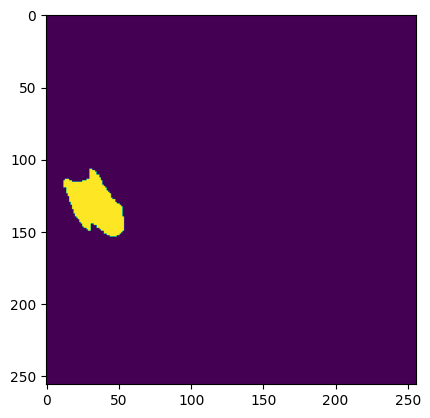

In [4]:
# %% test dataset class and dataloader
npz_tr_path = '../npz_wholebbox_pad/MRI_lesion/train'
demo_dataset = NpzDataset(npz_tr_path)
demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True)
for img_embed, gt2D, bboxes in demo_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    plt.imshow(gt2D[0,0,:,:])
    plt.show()
    break

In [4]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = '../npz_wholebbox_pad/MRI_lesion/train'
work_dir = './work_dir'
task_name = 'lesion_finetune_bgpoint'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()

# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


In [11]:
input_poin = np.array([[1,2]])
print(input_poin.shape)

print(input_poin[0])
onnx_coor = np.concatenate([input_poin], axis=0)[None, :, :]
point_torc = torch.as_tensor(onnx_coor, dtype=torch.float, device=device)
point_torc = point_torc.repeat((:,1,1))

print( point_torc.shape)
if len(point_torc.shape) == 3:
    point_torc = point_torc.expand(-1, -1, -1) # (B, 1, 4)
print( point_torc[0], point_torc.shape)


SyntaxError: invalid syntax (3140550130.py, line 7)

In [55]:
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
    print(image_embedding, gt2D, boxes, boxes.shape)
    break

self.img_embeddings.shape=(1701, 256, 64, 64), self.ori_gts.shape=(1701, 256, 256)


  0%|          | 0/26 [00:13<?, ?it/s]

tensor([[[[-4.8609e-02, -4.4043e-02, -4.9777e-02,  ..., -4.5911e-02,
           -4.2718e-02, -4.0678e-02],
          [-2.8842e-02, -2.2683e-02, -3.1983e-02,  ..., -2.1445e-02,
           -2.0765e-02, -2.8411e-02],
          [-3.5600e-02, -2.5596e-02, -3.5161e-02,  ..., -2.6256e-02,
           -2.5598e-02, -3.4048e-02],
          ...,
          [-1.9813e-02, -8.3534e-03, -1.8721e-02,  ...,  2.2664e-02,
            2.2381e-02,  3.6693e-03],
          [-1.3141e-02, -3.8614e-03, -1.4761e-02,  ...,  2.4325e-02,
            2.3892e-02,  5.2566e-03],
          [-2.8037e-02, -2.6059e-02, -3.5292e-02,  ..., -1.6640e-03,
           -2.1241e-03, -1.7719e-02]],

         [[ 2.9651e-02, -6.7351e-02, -6.6631e-02,  ..., -1.1304e-01,
           -1.2068e-01, -7.2586e-02],
          [-1.1960e-01, -1.6579e-01, -1.5928e-01,  ..., -1.8984e-01,
           -1.9534e-01, -1.7394e-01],
          [-8.2696e-02, -1.4772e-01, -1.2567e-01,  ..., -1.8223e-01,
           -1.8622e-01, -1.5142e-01],
          ...,
     

In [6]:
#%% train
num_epochs = 300
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder

        # print(f"{image_embedding.shape=}, {gt2D.shape=}, {bboxes.shape=}")
        with torch.no_grad():
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            foreground_point = np.array([[np.random.randint(0, gt2D.shape[-2]//2),np.random.randint(0, gt2D.shape[-1])]])
            foreground_label = np.array([1])
            background_point = np.array([[np.random.randint(gt2D.shape[-2]//2, gt2D.shape[-2]),np.random.randint(0, gt2D.shape[-1])]])
            background_label = np.array([0])

            onnx_coord = np.concatenate([foreground_point, background_point], axis=0)[None, :, :]
            point = sam_trans.apply_coords(onnx_coord, (gt2D.shape[-2], gt2D.shape[-1]))
            point_torch = torch.as_tensor(point, dtype=torch.float, device=device)
            onnx_label = np.concatenate([foreground_label, background_label], axis=0)[None, :].astype(np.float32)
            label_torch = torch.as_tensor(onnx_label, dtype=torch.float, device=device)
            point_torch = point_torch.repeat((64,1,1))
            label_torch = label_torch.repeat((64,1))

            point_tuple = (point_torch, label_torch)
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            # print(point_tuple, point_torch.shape, box_torch.shape, box_torch[0])
            # if len(point_torch.shape) == 1:
            #     point_torch = point_torch.expand(-1, -1, 64) # (B, 1, 4)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # print(point_tuple, point_torch.shape, box_torch.shape, box_np.shape)

            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=point_tuple,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))
    # break

self.img_embeddings.shape=(1701, 256, 64, 64), self.ori_gts.shape=(1701, 256, 256)


100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


EPOCH: 0, Loss: 0.6825231802463532


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 1, Loss: 0.40530417203903196


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 2, Loss: 0.32363170564174654


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 3, Loss: 0.28400407910346986


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 4, Loss: 0.2372274261713028


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 5, Loss: 0.20484134972095489


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 6, Loss: 0.1816388899087906


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 7, Loss: 0.17736809194087982


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 8, Loss: 0.15882803559303282


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 9, Loss: 0.1435227471590042


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 10, Loss: 0.1363293069601059


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 11, Loss: 0.13297866970300676


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 12, Loss: 0.12464097052812577


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 13, Loss: 0.12512372612953185


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 14, Loss: 0.11706839442253113


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 15, Loss: 0.11864195227622985


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 16, Loss: 0.11524619072675706


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 17, Loss: 0.1054125753045082


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 18, Loss: 0.1054578647017479


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 19, Loss: 0.10105788767337799


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 20, Loss: 0.09990334510803223


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 21, Loss: 0.09925734549760819


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 22, Loss: 0.0965610945224762


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 23, Loss: 0.093761745095253


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 24, Loss: 0.09253954201936722


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 25, Loss: 0.09141683548688889


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 26, Loss: 0.08956709355115891


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 27, Loss: 0.08894784212112426


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 28, Loss: 0.08671022713184356


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 29, Loss: 0.08551005721092224


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 30, Loss: 0.0855134356021881


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 31, Loss: 0.08392524242401123


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 32, Loss: 0.08498494535684585


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 33, Loss: 0.08364691525697708


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 34, Loss: 0.08171544581651688


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 35, Loss: 0.07928707301616669


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 36, Loss: 0.07805706858634949


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 37, Loss: 0.07798041075468064


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 38, Loss: 0.07718911543488502


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 39, Loss: 0.07607400119304657


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 40, Loss: 0.07498943105340004


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 41, Loss: 0.07382913947105407


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 42, Loss: 0.07379282981157304


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 43, Loss: 0.07387586742639542


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 44, Loss: 0.07372942045331002


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 45, Loss: 0.07220378905534744


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 46, Loss: 0.07188806772232055


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 47, Loss: 0.07092470794916153


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 48, Loss: 0.0698110656440258


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 49, Loss: 0.06852250680327415


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 50, Loss: 0.06777968108654023


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 51, Loss: 0.06689275085926055


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 52, Loss: 0.06649698510766029


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 53, Loss: 0.06740228787064552


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 54, Loss: 0.06584830567240715


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 55, Loss: 0.06702861741185188


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 56, Loss: 0.06448162525892258


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 57, Loss: 0.06416858807206154


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 58, Loss: 0.06271236464381218


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 59, Loss: 0.06253743425011635


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 60, Loss: 0.06109370082616806


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 61, Loss: 0.06099595442414284


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 62, Loss: 0.06069350630044937


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 63, Loss: 0.06047021359205246


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 64, Loss: 0.05985973671078682


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 65, Loss: 0.06009256139397621


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 66, Loss: 0.05864493533968926


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 67, Loss: 0.05740931138396263


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 68, Loss: 0.05743463158607483


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 69, Loss: 0.05870814263820648


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 70, Loss: 0.05706149414181709


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 71, Loss: 0.05639492020010948


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 72, Loss: 0.05491385132074356


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 73, Loss: 0.05682671889662742


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 74, Loss: 0.05500326305627823


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 75, Loss: 0.054342199712991715


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 76, Loss: 0.05334711790084839


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 77, Loss: 0.05344289109110832


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 78, Loss: 0.052643320858478546


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 79, Loss: 0.052946811467409136


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 80, Loss: 0.052699419409036635


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 81, Loss: 0.05311871260404587


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 82, Loss: 0.05183408141136169


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 83, Loss: 0.050616993606090545


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 84, Loss: 0.05062984794378281


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 85, Loss: 0.049824416637420654


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 86, Loss: 0.05012340158224106


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 87, Loss: 0.05024861931800842


100%|██████████| 26/26 [00:19<00:00,  1.36it/s]


EPOCH: 88, Loss: 0.05040452212095261


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 89, Loss: 0.04824710413813591


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 90, Loss: 0.04862826183438301


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 91, Loss: 0.04877155110239983


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 92, Loss: 0.04767166420817375


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 93, Loss: 0.047116431444883346


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 94, Loss: 0.04640117555856705


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 95, Loss: 0.04638436660170555


100%|██████████| 26/26 [00:18<00:00,  1.37it/s]


EPOCH: 96, Loss: 0.046584873348474505


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 97, Loss: 0.04598374247550965


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 98, Loss: 0.04592329144477844


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 99, Loss: 0.045940859019756315


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 100, Loss: 0.04480045348405838


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 101, Loss: 0.045299661308526994


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 102, Loss: 0.0443544103205204


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 103, Loss: 0.04369604930281639


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 104, Loss: 0.04367330476641655


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 105, Loss: 0.043715383112430575


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 106, Loss: 0.04351015895605087


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 107, Loss: 0.043365880250930786


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 108, Loss: 0.042440676391124726


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 109, Loss: 0.04154353052377701


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 110, Loss: 0.04115885928273201


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 111, Loss: 0.04132768839597702


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 112, Loss: 0.04217263862490654


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 113, Loss: 0.040767474472522734


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 114, Loss: 0.04124796152114868


100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


EPOCH: 115, Loss: 0.040736926048994065


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 116, Loss: 0.03991082802414894


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 117, Loss: 0.03973242074251175


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 118, Loss: 0.03915228620171547


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 119, Loss: 0.038910492956638336


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 120, Loss: 0.040025719255208966


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 121, Loss: 0.03856808125972748


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 122, Loss: 0.038725936710834505


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 123, Loss: 0.038114678561687466


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 124, Loss: 0.03789006486535072


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 125, Loss: 0.037567695081233976


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 126, Loss: 0.0373049508035183


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 127, Loss: 0.037470229864120484


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 128, Loss: 0.036777691096067426


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 129, Loss: 0.03662098705768585


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 130, Loss: 0.03594193071126938


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 131, Loss: 0.036538026183843615


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 132, Loss: 0.036196867674589156


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 133, Loss: 0.036294878348708155


100%|██████████| 26/26 [00:18<00:00,  1.37it/s]


EPOCH: 134, Loss: 0.03518134288489819


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 135, Loss: 0.03580384589731693


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 136, Loss: 0.03501189611852169


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 137, Loss: 0.03479230374097824


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 138, Loss: 0.03441163912415504


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 139, Loss: 0.03424658544361591


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 140, Loss: 0.03394055612385273


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 141, Loss: 0.03438736118376255


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 142, Loss: 0.03320977210998535


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 143, Loss: 0.032868253588676455


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 144, Loss: 0.032987056374549864


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 145, Loss: 0.03305929347872734


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 146, Loss: 0.03267699807882309


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 147, Loss: 0.03227325916290283


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 148, Loss: 0.031764351651072505


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 149, Loss: 0.03222500756382942


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 150, Loss: 0.032084800601005554


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 151, Loss: 0.03332411631941795


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 152, Loss: 0.03238711290061474


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 153, Loss: 0.03218534402549267


100%|██████████| 26/26 [00:19<00:00,  1.37it/s]


EPOCH: 154, Loss: 0.03114560343325138


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 155, Loss: 0.03093597888946533


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 156, Loss: 0.03045054592192173


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 157, Loss: 0.03044910542666912


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 158, Loss: 0.030447736382484436


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 159, Loss: 0.030054406225681306


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 160, Loss: 0.030021797940135


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 161, Loss: 0.029531668201088906


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 162, Loss: 0.02941880755126476


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 163, Loss: 0.029073501527309416


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 164, Loss: 0.029395716190338136


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 165, Loss: 0.03041306421160698


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 166, Loss: 0.030519607216119765


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 167, Loss: 0.03065315693616867


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 168, Loss: 0.029167757406830787


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 169, Loss: 0.02854845590889454


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 170, Loss: 0.028355941548943518


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 171, Loss: 0.028253263160586357


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 172, Loss: 0.02813675791025162


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 173, Loss: 0.028056305721402167


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 174, Loss: 0.027373248040676118


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 175, Loss: 0.027037165239453317


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 176, Loss: 0.02680568419396877


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 177, Loss: 0.027017705664038657


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 178, Loss: 0.026830526292324065


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 179, Loss: 0.026425598487257958


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 180, Loss: 0.02625061459839344


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 181, Loss: 0.02653301991522312


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 182, Loss: 0.026093813627958297


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 183, Loss: 0.026357609033584594


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 184, Loss: 0.02645638942718506


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 185, Loss: 0.025872573927044867


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 186, Loss: 0.025602587088942527


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 187, Loss: 0.02552909180521965


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 188, Loss: 0.025663866400718688


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 189, Loss: 0.025767842158675194


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 190, Loss: 0.024955116435885428


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 191, Loss: 0.025154846608638762


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 192, Loss: 0.024576945826411248


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 193, Loss: 0.024787208288908003


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 194, Loss: 0.024606324657797815


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 195, Loss: 0.02439787209033966


100%|██████████| 26/26 [00:19<00:00,  1.36it/s]


EPOCH: 196, Loss: 0.02393925964832306


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 197, Loss: 0.024128191843628882


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 198, Loss: 0.02403367221355438


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 199, Loss: 0.02416148915886879


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 200, Loss: 0.024268405437469484


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 201, Loss: 0.02393128424882889


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 202, Loss: 0.0232923024892807


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 203, Loss: 0.023319512456655502


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 204, Loss: 0.023306424096226692


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 205, Loss: 0.02278603434562683


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 206, Loss: 0.0226028823107481


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 207, Loss: 0.022727413401007653


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 208, Loss: 0.02292906142771244


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 209, Loss: 0.022705105394124986


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 210, Loss: 0.022436494082212446


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 211, Loss: 0.022029170095920564


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 212, Loss: 0.022105969414114954


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 213, Loss: 0.021928970366716385


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 214, Loss: 0.02221183240413666


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 215, Loss: 0.02212219566106796


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 216, Loss: 0.021704335138201712


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 217, Loss: 0.021984538659453393


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 218, Loss: 0.02161540202796459


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 219, Loss: 0.021220899596810342


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 220, Loss: 0.021245833933353424


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 221, Loss: 0.021066182926297188


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 222, Loss: 0.0209262578189373


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 223, Loss: 0.020719712227582933


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 224, Loss: 0.020747355371713638


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 225, Loss: 0.020675686448812486


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 226, Loss: 0.0214180988073349


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 227, Loss: 0.02146351121366024


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 228, Loss: 0.020593021512031556


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 229, Loss: 0.020294881239533425


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 230, Loss: 0.020246968045830725


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 231, Loss: 0.020103930681943893


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 232, Loss: 0.02003428652882576


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 233, Loss: 0.01996840089559555


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 234, Loss: 0.019499623477458955


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 235, Loss: 0.019580172076821327


100%|██████████| 26/26 [00:18<00:00,  1.37it/s]


EPOCH: 236, Loss: 0.019645330011844635


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 237, Loss: 0.019371342211961746


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 238, Loss: 0.019529851749539376


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 239, Loss: 0.019946816191077233


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 240, Loss: 0.019215013459324838


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 241, Loss: 0.019030428901314737


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 242, Loss: 0.019035369902849198


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 243, Loss: 0.019218888729810715


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


EPOCH: 244, Loss: 0.018888933435082435


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 245, Loss: 0.018609550967812537


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 246, Loss: 0.018349273055791857


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 247, Loss: 0.018449019566178324


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 248, Loss: 0.018280459493398668


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 249, Loss: 0.01827216774225235


100%|██████████| 26/26 [00:18<00:00,  1.39it/s]


EPOCH: 250, Loss: 0.01815745647996664


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 251, Loss: 0.018165355399250984


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 252, Loss: 0.018457251861691476


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 253, Loss: 0.01811013784259558


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 254, Loss: 0.01818039532750845


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 255, Loss: 0.01777736786752939


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 256, Loss: 0.017643874622881413


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 257, Loss: 0.017549683637917042


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 258, Loss: 0.017470811679959296


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 259, Loss: 0.017433211766183378


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 260, Loss: 0.017608774788677693


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 261, Loss: 0.01725815888494253


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 262, Loss: 0.017702299058437346


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 263, Loss: 0.018997539058327673


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 264, Loss: 0.017636724784970283


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 265, Loss: 0.017300160229206087


100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


EPOCH: 266, Loss: 0.01729869082570076


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 267, Loss: 0.01670296210795641


100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


EPOCH: 268, Loss: 0.016647150628268718


100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


EPOCH: 269, Loss: 0.016505270376801492


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 270, Loss: 0.016317515894770623


100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


EPOCH: 271, Loss: 0.01643029000610113


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 272, Loss: 0.016404089480638505


100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


EPOCH: 273, Loss: 0.016104525923728942


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 274, Loss: 0.01622000355273485


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 275, Loss: 0.01627785224467516


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 276, Loss: 0.01625731445848942


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 277, Loss: 0.016019920632243157


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 278, Loss: 0.01632533222436905


100%|██████████| 26/26 [00:18<00:00,  1.40it/s]


EPOCH: 279, Loss: 0.015899116061627864


100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


EPOCH: 280, Loss: 0.015719685293734072


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 281, Loss: 0.015691490061581135


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 282, Loss: 0.015673527009785176


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 283, Loss: 0.015504616573452949


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 284, Loss: 0.015483406223356724


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 285, Loss: 0.015476735271513463


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 286, Loss: 0.015231347754597663


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 287, Loss: 0.015214429944753647


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 288, Loss: 0.015257168263196945


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 289, Loss: 0.015415594354271889


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 290, Loss: 0.016174130849540235


100%|██████████| 26/26 [00:18<00:00,  1.43it/s]


EPOCH: 291, Loss: 0.015367058627307415


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 292, Loss: 0.015012151673436164


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 293, Loss: 0.015062587037682533


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 294, Loss: 0.015121883377432824


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 295, Loss: 0.01470620058476925


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 296, Loss: 0.014761250130832196


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 297, Loss: 0.014579453580081463


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


EPOCH: 298, Loss: 0.01467878133058548


100%|██████████| 26/26 [00:18<00:00,  1.41it/s]


EPOCH: 299, Loss: 0.014654075913131236


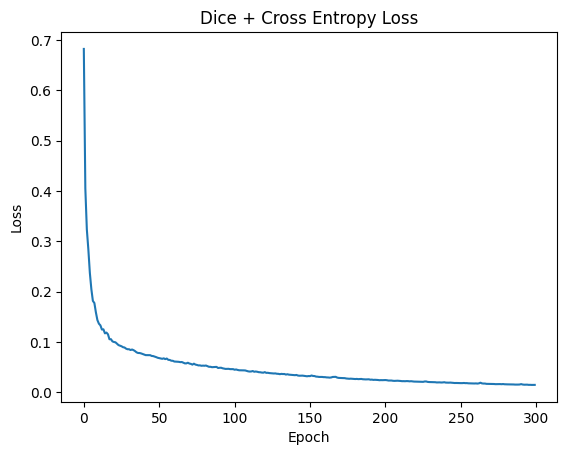

In [7]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [15]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_type = 'vit_b'
ori_sam_model = sam_model_registry[model_type](checkpoint='/scratch/itee/uqtdao4/seg_volume/MedSAM/work_dir/lesion_finetune_pointbox/sam_model_latest.pth').to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)
# npz_ts_path = '../brain_data/npz_wholebbox/MRI_lesion/train/'
# test_npzs = sorted(os.listdir(npz_ts_path))
# random select a test case
# np.random.seed(2023)
# # npz_idx = np.random.randint(0, len(test_npzs))
# print(len(test_npzs))
# npz_idx = 5
# print(test_npzs[npz_idx])
npz = np.load('../npz_wholebbox_pad/MRI_lesion/train/MRI_lesion_sub-M2002_ses-a1440_T2w.npz')
imgs = npz['imgs']
gts = npz['gts']
print(f"{imgs.shape=}, {gts.shape=}")

def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    # y_indices, x_indices = np.where(mask > 0)
    # x_min, x_max = np.min(x_indices), np.max(x_indices)
    # y_min, y_max = np.min(y_indices), np.max(y_indices)
    # # add perturbation to bounding box coordinates
    # H, W = mask.shape
    # np.random.seed(2023)
    # x_min = max(0, x_min - np.random.randint(0, 20))
    # x_max = min(W, x_max + np.random.randint(0, 20))
    # y_min = max(0, y_min - np.random.randint(0, 20))
    # y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = np.array([0, 0, mask.shape[1], mask.shape[0]])
    # return np.array([x_min, y_min, x_max, y_max])
    return bbox

imgs.shape=(81, 256, 256, 3), gts.shape=(81, 256, 256)


(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
ori mean= 40.29933166503906 std= 62.145723077055955 min= 0 max= 255
preprocess mean= 40.29933166503906 std= 62.145723077055955 min= 0 max= 255


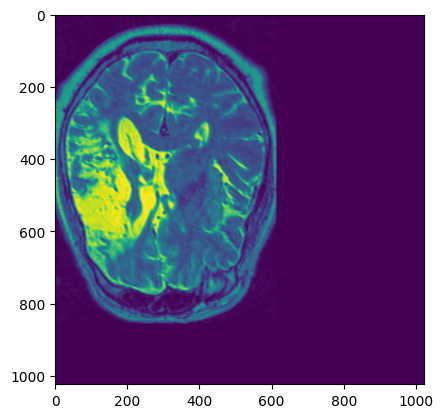

sam trans mean= 40.3557243347168 std= 61.29097132164338 min= 0 max= 255
preprocess mean= -1.2857021 std= 1.0723925 min= -2.117904 max= 2.64
embedding mean= 0.011695392 std= 0.1572394 min= -1.0248413 max= 0.81036264
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)
(81, 256, 256)


In [21]:
# infer on fine-tuned sam model
medsam_segs = []
bboxes = []
for i, (img, gt) in enumerate(zip(imgs, gts)):
    print(gts.shape)
    # bbox = get_bbox_from_mask(gt)
    if i != 33: 
        continue
    bbox = np.array([0 ,0, img.shape[0], img.shape[1]])
    # bbox = np.array([50, img.shape[0]-1, img.shape[1]-1, 50])
    bboxes.append(bbox)
    
    # predict the segmentation mask using the fine-tuned model
    sam_model = sam_model_registry[model_type](checkpoint='/scratch/itee/uqtdao4/seg_volume/MedSAM/work_dir/lesion_finetune_bgpoint/sam_model_latest.pth').to(device)

    sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
    H, W = img.shape[:2]
    print("ori mean=", np.mean(img), "std=", np.std(img), "min=", np.min(img), "max=", np.max(img))

    print("preprocess mean=", np.mean(img), "std=", np.std(img), "min=", np.min(img), "max=", np.max(img))

    resize_img = sam_trans.apply_image(img)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    x = input_image.cpu().data.numpy()
    plt.imshow(resize_img[:,:,0])
    plt.show()
    print("sam trans mean=", np.mean(resize_img), "std=", np.std(resize_img), "min=", np.min(resize_img), "max=", np.max(resize_img))
    print("preprocess mean=", np.mean(x), "std=", np.std(x), "min=", np.min(x), "max=", np.max(x))
    
    with torch.no_grad():
        image_embedding = sam_model.image_encoder(input_image.to(device)) # (1, 256, 64, 64)
        print("embedding mean=", np.mean(image_embedding.cpu().data.numpy()), "std=", np.std(image_embedding.cpu().data.numpy()), "min=", np.min(image_embedding.cpu().data.numpy()), "max=", np.max(image_embedding.cpu().data.numpy()))
        
        # convert box to 1024x1024 grid
        input_point = np.array([[35,143]])
        onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]

        point = sam_trans.apply_coords(onnx_coord, (H, W))
        point_torch = torch.as_tensor(point, dtype=torch.float, device=device)
        label = np.array([1])
        onnx_label = np.concatenate([label, np.array([-1])], axis=0)[None, :].astype(np.float32)

        label_torch = torch.as_tensor(onnx_label, dtype=torch.float, device=device)
        
        point_tuple = (point_torch, label_torch)
        bbox = sam_trans.apply_boxes(bbox, (H, W))
        box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)

        # if box_coords is None:
        #     box_coords = np.array([[0.0, 0.0]])
        #     box_labels = np.array([-1])
        # else:
        #     box_coords = box_coords.reshape(2, 2)
            
        # if point_coords is None or len(point_coords) == 0:
        #     point_coords = np.array([[0.0, 0.0]])
        #     point_labels = np.array([0])

        # coords = np.concatenate([point_coords, box_coords], axis=0)[None, :, :]
        # labels = np.concatenate([point_labels, box_labels], axis=0)[None, :].astype(
        #     np.float32
        # )
        # coords = sam_trans.apply_coords(coords, img.shape[:2]).astype(np.float32)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 1, 4)
        
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=point_tuple,
            boxes=box_torch,
            masks=None,
        )
        medsam_seg_prob, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
        medsam_segs.append(medsam_seg)

In [22]:
medsam_segs = np.stack(medsam_segs, axis=0)
medsam_segs.shape

(1, 256, 256)

In [53]:
print("pad mean=", np.mean(medsam_segs[0]), "std=", np.std(medsam_segs[0]), "min=", np.min(medsam_segs[0]), "max=", np.max(medsam_segs[0]))

pad mean= 0.0121917724609375 std= 0.10974120987668318 min= 0 max= 1


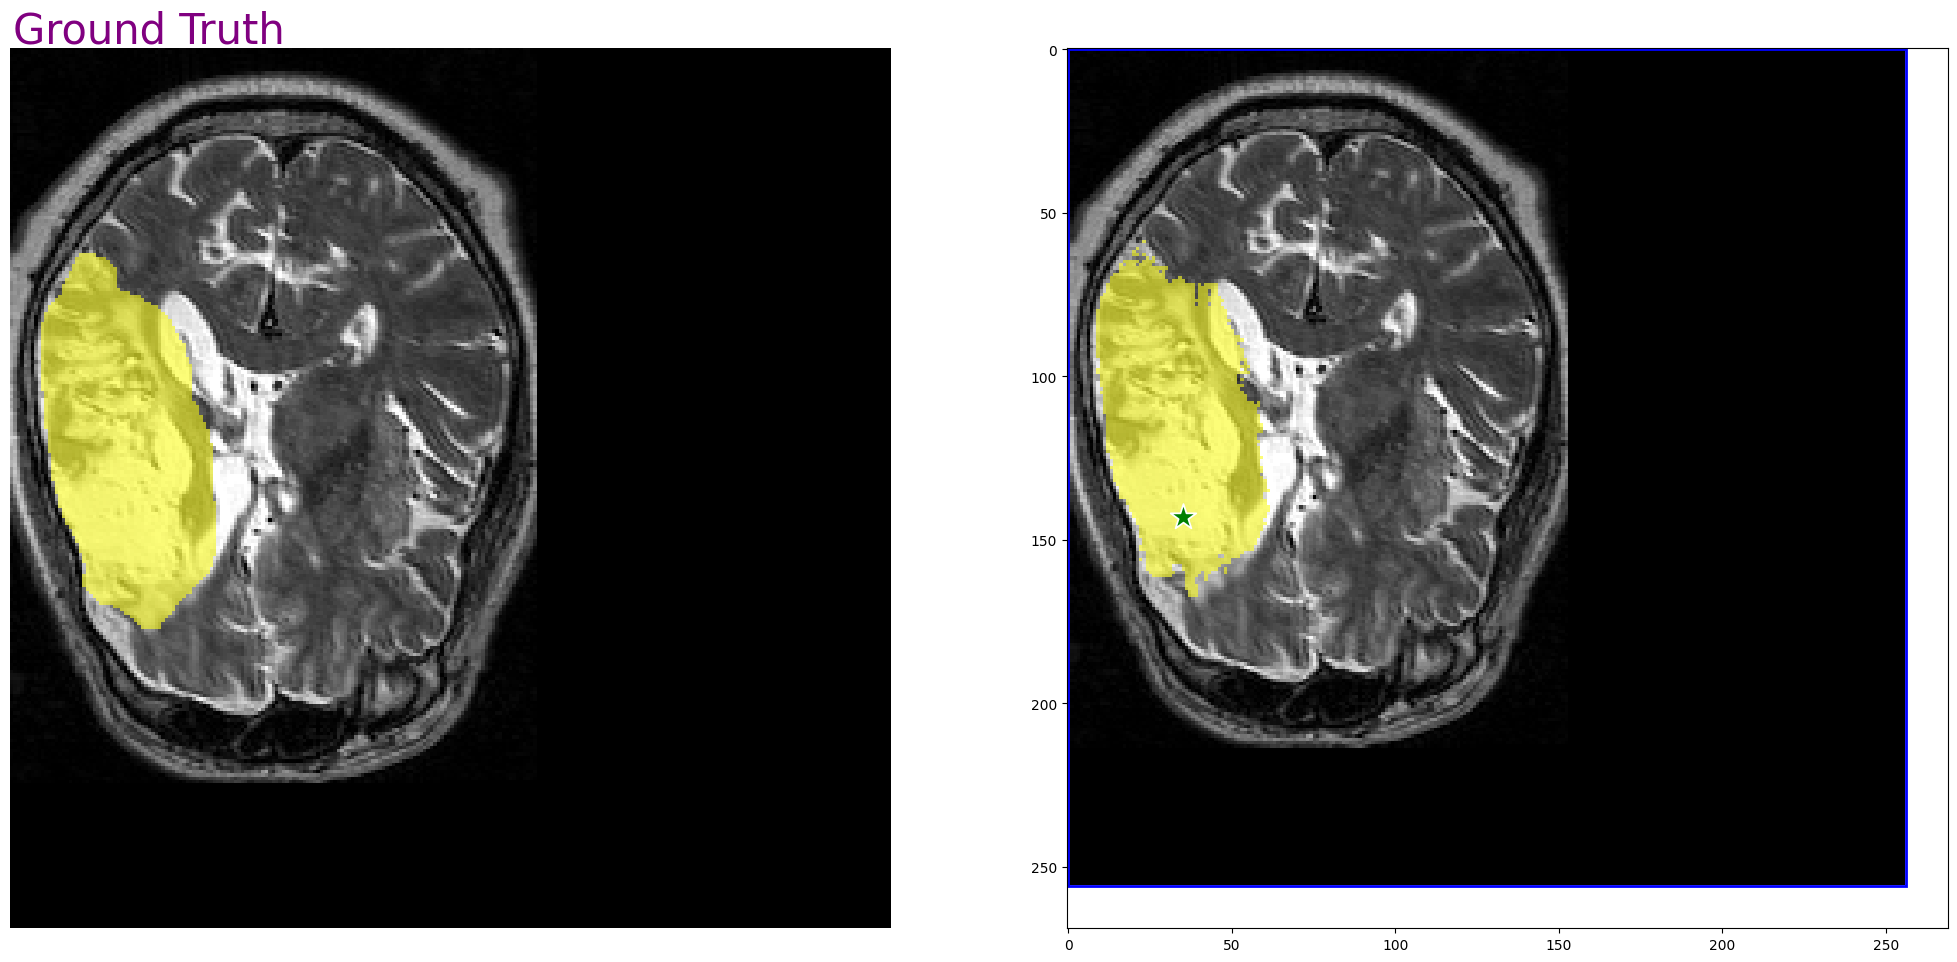

In [23]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
   
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    
img_id = 0 #63
# img_id = int(imgs.shape[0]/2)  # np.random.randint(imgs.shape[0])
_, axs = plt.subplots(1, 2, figsize=(25, 25))
axs[0].imshow(imgs[img_id+33])
show_mask(gts[img_id+33], axs[0])
# show_box(box_np[img_id], axs[0][0])
# axs[0][0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].text(0.5, 0.5,'Ground Truth', fontsize=30, horizontalalignment='left', verticalalignment='bottom', color='purple')
axs[0].axis('off')

axs[1].imshow(imgs[img_id+33])
show_mask(medsam_segs[img_id, :, :,], axs[1])
show_points(np.array([[35,143]]), np.array([1]), axs[1])

show_box(bboxes[img_id], axs[1])
# add text to image to show dice score
# axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='bottom', color='purple')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('on')

plt.show()

In [18]:
import nibabel as nib

label_id = 3
idx = test_npzs[npz_idx].split('_')[2]
print(idx)
ori_gt = nib.load(join('./trainingset_51/labels/final', idx + '_W.nii.gz')).get_fdata()
ori_img = nib.load(join('./trainingset_51', idx + '_W.nii.gz')).get_fdata()
ori_gt = np.uint8(ori_gt==label_id)
_, y_index, z_index = np.where(ori_gt > 0)
z_min, z_max = np.min(z_index), np.max(z_index)
print(z_min, z_max)
# print(list(range(z_min, z_max)))

index_filter = []
gts = []
for i in range(z_min, z_max):
    gt_slice_i = ori_gt[:,:,i]
    gt_slice_i = transform.resize(gt_slice_i, (256, 256), order=0, preserve_range=True, mode='constant', anti_aliasing=True)

    if np.sum(gt_slice_i) > 3:
        index_filter.append(i)
        gts.append(gt_slice_i)
    else:
        print('noise index', i)
z_min_fl, z_max_fl = np.min(index_filter), np.max(index_filter)
# print('index filter',len(index_filter), index_filter)
print(z_min_fl, z_max_fl)
# print(list(range(z_min_fl, z_max_fl)))
# print(len(gts))

sub-16310.FatImaging
55 82
55 81


In [19]:
medsam_segs.shape

(27, 256, 256)

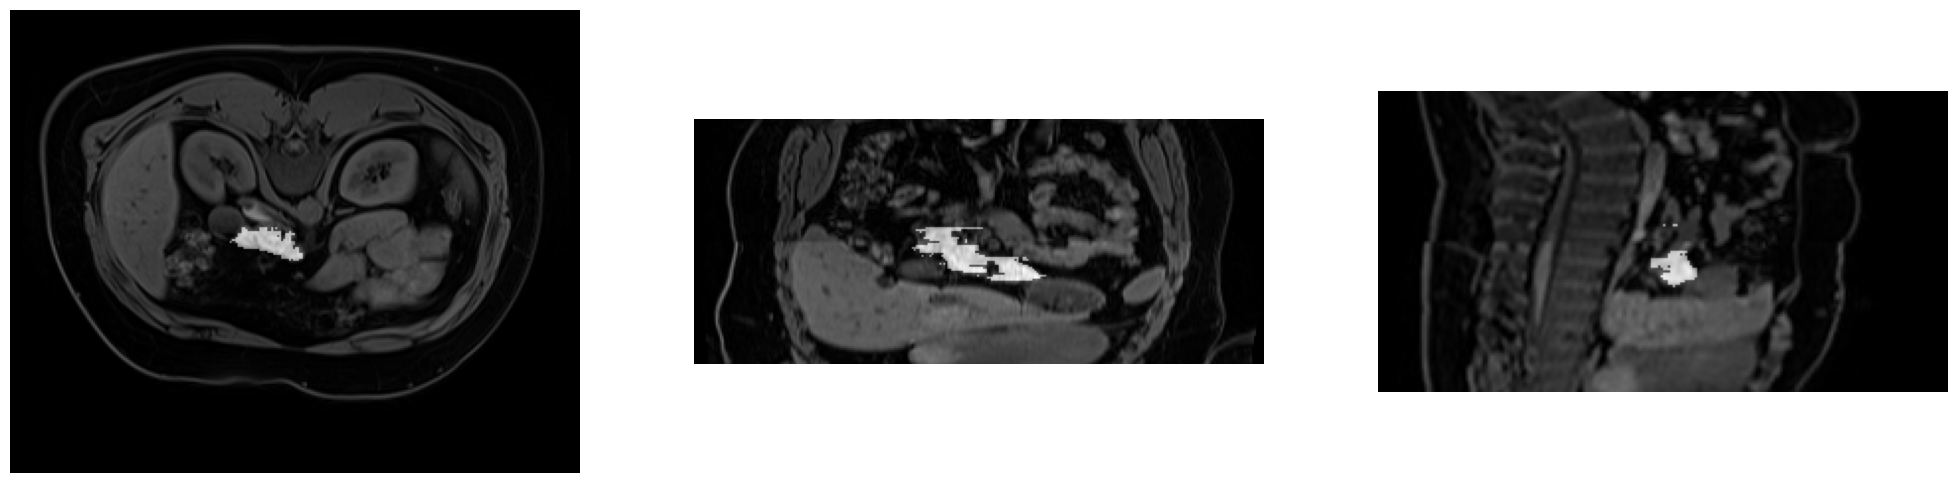

In [20]:
import skimage

ori_size = (288, 234, 124)
ori_zeros = np.zeros(ori_size)
medsam_segs_T = np.stack(medsam_segs).T # 256,256,x
# resize prediction to original size
medsan_segs_resized = skimage.transform.resize(medsam_segs_T, (288, 234, medsam_segs_T.shape[2]), order=0, preserve_range=True)
ori_zeros[:,:, z_min_fl:z_max_fl+1] += medsan_segs_resized
fig, axs  = plt.subplots(1,3, figsize=(25, 25))

axs[0].imshow(ori_img[:,:,66].T, cmap='gray')
axs[0].imshow(ori_zeros[:, :, 66].T, cmap='gray', alpha=0.5)
axs[0].axis('off')

axs[1].imshow(ori_img[:,117,:].T, cmap='gray')
axs[1].imshow(ori_zeros[:, 117, :].T, cmap='gray', alpha=0.5)
axs[1].axis('off')

axs[2].imshow(ori_img[144,:,:].T, cmap='gray')
axs[2].imshow(ori_zeros[144, :, :].T, cmap='gray', alpha=0.5)
axs[2].axis('off')
plt.show()


In [172]:
ori_gt_nii = nib.load(join('./trainingset_51/labels/final', idx + '_W.nii.gz'))
nib.save(nib.Nifti1Image(ori_zeros, ori_gt_nii.affine, ori_gt_nii.header), os.path.join('segmentation_output/segmentation_nii', idx + '_W.nii.gz'))